In [1]:
# Define code:
from bb_ions import *

# [[30, 4, 5]] From Ye Delfosse long chain [2503.22071]:
l = 5
m = 3
# A = x^0 + x
# B = x^0 + y + x^2*y^2   (from Table II)

Aij = [(0, 0), (1, 0)]
Bij = [(0, 0), (0, 1), (2, 2)]
code = get_code_params(l, m, Aij, Bij)

In [ ]:
import stim
from bb_ions import *

basis = 'Z' # preserve logical 0 or +

reuse_check_qubits = True # one check register, possible as we're doing X-checks then Z-checks
sequential = True # whether or not the two-qubit gates within a leg are sequential or in parallel


# we've got 2lm data qubits. 
# Modules are of size 2l.
# So m check modules, m data qubit modules. 
# For 30,4,5 this is 3 check modules, 3 data modules. I.e. w = 0, 1, 2. v = 0, 1, 2, 3, 4. 
# So for a given v, we will see three CNOTs


registers = make_registers(l, m, reuse_check_qubits = reuse_check_qubits)
qX = registers.qX
qL = registers.qL
qR = registers.qR
qZ = registers.qZ  # qZ will equal qX if reuse_check_qubits == True


## Circuit paramaters:



all_t = 0.001
t_init = all_t
t_had = all_t
t_merge = all_t
t_split = all_t
t_cnot = all_t
t_cz = all_t
t_shuttle_0 = all_t
t_shift_const = all_t
t_meas = all_t


# Assign qubit registers:

circ = stim.Circuit()

## Round 0:
# - wait's a time step to initalise data qubits
# - only puts detectors on X (Z) -checks if preparing logical |+⟩ (|0⟩)


# X-CHECKS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

qC = qX

# Initialise X-check qubits
init('Z', circ, qC, t_init)
tick(circ)

# Hadamard check qubits to |+⟩ and initalise data qubits:
hadamard(circ, qC, t_had)
init(basis, circ, qL + qR, t_init) # initialise data qubits to +1 eigenstate of 'basis' 
tick(circ)

Junion = code.Junion

jval_prev = Junion[0] # we assume the starting arrangement of the modules is M^a_w with M^d_((w + j) % m), i.e. no cyclic shift required initially (this will be reflected in t_shift = 0 and therefore apply_shift_error and idle functions below not appending any errors)

# Do cyclic shifts to required j-valued modules

for jval in Junion:

    # Cyclic shift the check qubits
    t_shift = t_shift_const * abs((jval % m) - (jval_prev % m)) # saying t_shfit ∝ c * (j - prev_j) -- also in case a power of y accidentally wasn't modulo (e.g. y^5 while m = 3), the modulos here means the actual shift error will still be calculated
    apply_shift_error(circ, qC, t_shift)
    idle(circ, qL + qR, t_shift) # idle the data qubits 
    tick(circ)

    # Shuttle check qubit modules from racetrack into leg:
    apply_shuttle_error(circ, qC, t_shuttle_0)
    idle(circ, qL + qR, t_shuttle_0) # idle the data qubits
    tick(circ)

    # Merge check and data qubit modules Coulomb potentials:
    apply_merge_error(circ, qC + qL + qR, t_merge)
    tick(circ)

    # Apply CNOTs for X-checks
    add_A_CNOTs(circ, jval, code, registers, t_cnot, sequential) # CNOTs for i such that x^i⋅y^j appears in A
    add_B_CNOTs(circ, jval, code, registers, t_cnot, sequential) # CNOTs for i such that x^i⋅y^j appears in B

    # # Split coulomb potentials of data qubit modules from check qubit modules:
    apply_split_error(circ, qC + qL + qR, t_split)
    tick(circ)

    # # Shuttle check qubits from leg into racetrack:
    apply_shuttle_error(circ, qC, t_shuttle_0)
    idle(circ, qL + qR, t_shuttle_0) # idle the data qubits
    tick(circ)

    jval_prev = jval

# # Alrighty we've done the X-check CNOTs!

# Now to hadamard the check qubits then measure them (they've already been shuttled back into racetrack)
hadamard(circ, qC, t_had)
idle(circ, qL + qR, t_had)
tick(circ)
measure(circ, qC, t_meas)
idle(circ, qL + qR, t_meas)
tick(circ)

# If preserving logical plus we put detectors on these checks in the first round:
n = code.n
if basis == 'X':
    for i in reversed(range(1, n//2 + 1)): # appends detectors to last n/2 measurements (i.e. from rec[-1] to rec[-n/2])
        circ.append("DETECTOR", [stim.target_rec(-i)])


# # Z-CHECKS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

qC = qZ

'''Basically the same as X-checks except:
    - ATij, BTij (from which JTunion is constructed) have (-i,-j) of Aij, Bij
    - will probably have to cyclic shift the very first check (taken care of)
    - Link B^T with LEFT data qubits and A^T with RIGHT data qubits because Hz = [B^T|A^T]
    - CZ's instead of CNOTs 
    - detectors on these if preserving logical 0 (basis == 'Z' )'''

# Initialise Z-check qubits
init('Z', circ, qC, t_init) # (note qZ = qX if reuse_check_qubits == True)
idle(circ, qL + qR, t_init) # idle data qubits
tick(circ)

# Hadamard check qubits to |+⟩ and initalise data qubits:
hadamard(circ, qC, t_had)
idle(circ, qL + qR, t_init) # idle data qubits
tick(circ)

JTunion = code.JTunion

# Do cyclic shifts to required j-valued modules

for jval in JTunion: 

    # Cyclic shift the check qubits (unless jval = jprev then no errors will be applied)
    t_shift = t_shift_const * abs((jval % m) - (jval_prev % m)) # saying t_shfit propto c * (j - prev_j) (also turning -ve jvalues into what they'd actually be ... though will keep them actually negative for when being used in v ⊕ i, w ⊕ j in the CZ functions)
    apply_shift_error(circ, qC, t_shift)
    idle(circ, qL + qR, t_shift) # idle the data qubits 
    tick(circ)

    # Shuttle check qubit modules from racetrack into leg:
    apply_shuttle_error(circ, qC, t_shuttle)
    idle(circ, qL + qR, t_shuttle) # idle the data qubits
    tick(circ)

    # Merge check and data qubit modules Coulomb potentials:
    apply_merge_error(circ, qC + qL + qR, t_merge)
    tick(circ)

    # Add CZs:
    add_BT_CZs(circ, jval, code, registers, t_cz, sequential)
    add_AT_CZs(circ, jval, code, registers, t_cz, sequential)

    # # Split coulomb potentials of data qubit modules from check qubit modules:
    apply_split_error(circ, qC + qL + qR, t_split)
    tick(circ)

    # # Shuttle check qubits from leg into racetrack:
    apply_shuttle_error(circ, qC, t_shuttle)
    idle(circ, qL + qR, t_shuttle) # idle the data qubits
    tick(circ)

    jval_prev = jval


# # Alrighty we've done the Z-check CZs!

# Now to hadamard the check qubits then measure them (they've already been shuttled back into racetrack)
hadamard(circ, qC, t_had)
idle(circ, qL + qR, t_had)
tick(circ)
measure(circ, qC, t_meas)
idle(circ, qL + qR, t_meas)
tick(circ)

# If preserving logical zero we put detectors on these (Z) checks in the first round:
n = code.n
if basis == 'Z':
    for i in reversed(range(1, n//2 + 1)): # appends detectors to last n/2 measurements (i.e. from rec[-1] to rec[-n/2])
        circ.append("DETECTOR", [stim.target_rec(-i)])



## We will now append the repeated block / "loop body", which basically is the same as the first round except:
# -- no initalising of data qubits, they simply idle while check qubits are being prepared
# -- we'll put detectors on both X and Z checks (unless exclude_opposite_basis_detectors = True)





svg = str(circ.diagram("timeline-svg"))
with open("output.svg", "w", encoding="utf-8") as f: f.write(svg)

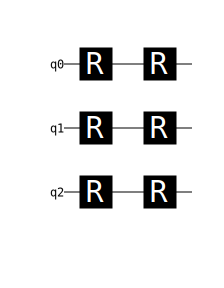

In [ ]:
loop_body = stim.Circuit()

# Now the X-checks and Z-checks will have like exactly the same structure, just set qC = qX or qZ and append CNOTs or CZs (which automatically have Aij, Bij, ATij or BTij in them)



# # X-CHECKS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# qC = qX

# # Initialise X-check qubits
# init('Z', loop_body, qC, t_init)
# idle()
# tick(loop_body)

# # Hadamard check qubits to |+⟩ and initalise data qubits:
# hadamard(loop_body, qC, t_had)

# tick(loop_body)

# Junion = code.Junion

# jval_prev = Junion[0] # we assume the starting arrangement of the modules is M^a_w with M^d_((w + j) % m), i.e. no cyclic shift required initially (this will be reflected in t_shift = 0 and therefore apply_shift_error and idle functions below not appending any errors)

# # Do cyclic shifts to required j-valued modules

# for jval in Junion:

#     # Cyclic shift the check qubits
#     t_shift = t_shift_const * abs((jval % m) - (jval_prev % m)) # saying t_shfit ∝ c * (j - prev_j) -- also in case a power of y accidentally wasn't modulo (e.g. y^5 while m = 3), the modulos here means the actual shift error will still be calculated
#     apply_shift_error(loop_body, qC, t_shift)
#     idle(loop_body, qL + qR, t_shift) # idle the data qubits 
#     tick(loop_body)

#     # Shuttle check qubit modules from racetrack into leg:
#     apply_shuttle_error(loop_body, qC, t_shuttle_0)
#     idle(loop_body, qL + qR, t_shuttle_0) # idle the data qubits
#     tick(loop_body)

#     # Merge check and data qubit modules Coulomb potentials:
#     apply_merge_error(loop_body, qC + qL + qR, t_merge)
#     tick(loop_body)

#     # Apply CNOTs for X-checks
#     add_A_CNOTs(loop_body, jval, code, registers, t_cnot, sequential) # CNOTs for i such that x^i⋅y^j appears in A
#     add_B_CNOTs(loop_body, jval, code, registers, t_cnot, sequential) # CNOTs for i such that x^i⋅y^j appears in B

#     # # Split coulomb potentials of data qubit modules from check qubit modules:
#     apply_split_error(loop_body, qC + qL + qR, t_split)
#     tick(loop_body)

#     # # Shuttle check qubits from leg into racetrack:
#     apply_shuttle_error(loop_body, qC, t_shuttle_0)
#     idle(loop_body, qL + qR, t_shuttle_0) # idle the data qubits
#     tick(loop_body)

#     jval_prev = jval

# # # Alrighty we've done the X-check CNOTs!

# # Now to hadamard the check qubits then measure them (they've already been shuttled back into racetrack)
# hadamard(loop_body, qC, t_had)
# idle(loop_body, qL + qR, t_had)
# tick(loop_body)
# measure(loop_body, qC, t_meas)
# idle(loop_body, qL + qR, t_meas)
# tick(loop_body)

# # If preserving logical plus we put detectors on these checks in the first round:
# n = code.n
# if basis == 'X':
#     for i in reversed(range(1, n//2 + 1)): # appends detectors to last n/2 measurements (i.e. from rec[-1] to rec[-n/2])
#         loop_body.append("DETECTOR", [stim.target_rec(-i)])


# # # Z-CHECKS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# qC = qZ

# '''Basically the same as X-checks except:
#     - ATij, BTij (from which JTunion is constructed) have (-i,-j) of Aij, Bij
#     - will probably have to cyclic shift the very first check (taken care of)
#     - Link B^T with LEFT data qubits and A^T with RIGHT data qubits because Hz = [B^T|A^T]
#     - CZ's instead of CNOTs 
#     - detectors on these if preserving logical 0 (basis == 'Z' )'''

# # Initialise Z-check qubits
# init('Z', loop_body, qC, t_init) # (note qZ = qX if reuse_check_qubits == True)
# idle(loop_body, qL + qR, t_init) # idle data qubits
# tick(loop_body)

# # Hadamard check qubits to |+⟩ and initalise data qubits:
# hadamard(loop_body, qC, t_had)
# idle(loop_body, qL + qR, t_init) # idle data qubits
# tick(loop_body)

# JTunion = code.JTunion

# # Do cyclic shifts to required j-valued modules

# for jval in JTunion: 

#     # Cyclic shift the check qubits (unless jval = jprev then no errors will be applied)
#     t_shift = t_shift_const * abs((jval % m) - (jval_prev % m)) # saying t_shfit propto c * (j - prev_j) (also turning -ve jvalues into what they'd actually be ... though will keep them actually negative for when being used in v ⊕ i, w ⊕ j in the CZ functions)
#     apply_shift_error(loop_body, qC, t_shift)
#     idle(loop_body, qL + qR, t_shift) # idle the data qubits 
#     tick(loop_body)

#     # Shuttle check qubit modules from racetrack into leg:
#     apply_shuttle_error(loop_body, qC, t_shuttle)
#     idle(loop_body, qL + qR, t_shuttle) # idle the data qubits
#     tick(loop_body)

#     # Merge check and data qubit modules Coulomb potentials:
#     apply_merge_error(loop_body, qC + qL + qR, t_merge)
#     tick(loop_body)

#     # Add CZs:
#     add_BT_CZs(loop_body, jval, code, registers, t_cz, sequential)
#     add_AT_CZs(loop_body, jval, code, registers, t_cz, sequential)

#     # # Split coulomb potentials of data qubit modules from check qubit modules:
#     apply_split_error(loop_body, qC + qL + qR, t_split)
#     tick(loop_body)

#     # # Shuttle check qubits from leg into racetrack:
#     apply_shuttle_error(loop_body, qC, t_shuttle)
#     idle(loop_body, qL + qR, t_shuttle) # idle the data qubits
#     tick(loop_body)

#     jval_prev = jval


# # # Alrighty we've done the Z-check CZs!

# # Now to hadamard the check qubits then measure them (they've already been shuttled back into racetrack)
# hadamard(loop_body, qC, t_had)
# idle(loop_body, qL + qR, t_had)
# tick(loop_body)
# measure(loop_body, qC, t_meas)
# idle(loop_body, qL + qR, t_meas)
# tick(loop_body)

# # If preserving logical zero we put detectors on these (Z) checks in the first round:
# n = code.n
# if basis == 'Z':
#     for i in reversed(range(1, n//2 + 1)): # appends detectors to last n/2 measurements (i.e. from rec[-1] to rec[-n/2])
#         loop_body.append("DETECTOR", [stim.target_rec(-i)])


